In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

ERR = 1e-100

# Non-homogenous Markov Chain for Actuarial Purposes

## Part 1: The Live-Death Model

### Ultimate Survival Model

In [2]:
from scipy.integrate import quad

def compute_mu(x):
    A = 0.00022
    B = 2.7e-6
    c = 1.124
    return A + B * c**x

def prob_of_living(x0, t):
    """
    x = current age
    t = number of years left
    => Pr[Living another t years | You are x y/o]
    """
    integral_val, _ = quad(lambda s: compute_mu(x0 + s), 0, t)
    return np.exp(-integral_val)

<Axes: xlabel="$t$'s", ylabel='Pr[Living t more years]'>

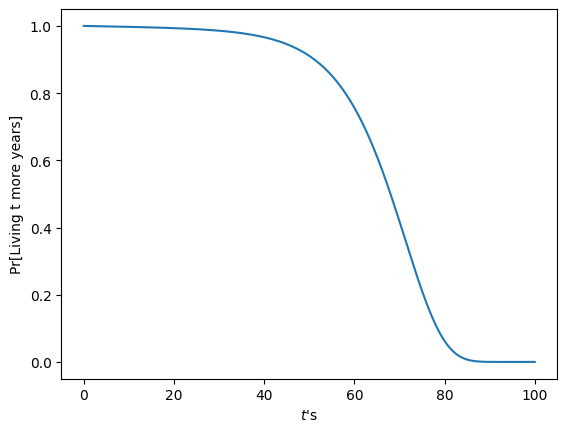

In [3]:
starting_age = 20
ts = np.linspace(0, 100, 200)
ys = [prob_of_living(starting_age, t) for t in ts]

tp_data = pd.DataFrame({
    "$t$'s": ts,
    "Pr[Living t more years]": ys,
})

sns.lineplot(tp_data, x="$t$'s", y="Pr[Living t more years]")

<Axes: xlabel="$t$'s">

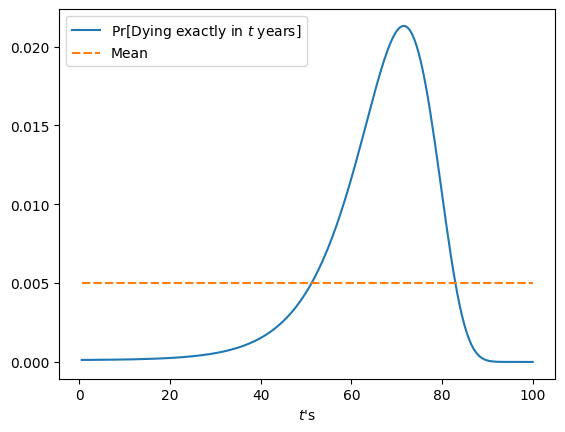

In [4]:
qs = np.abs(np.diff(ys))
qs_mean = np.mean(qs)

tq_data = pd.DataFrame({
    "$t$'s": ts[1:],
    "Pr[Dying exactly in $t$ years]": qs,
    "Mean": qs_mean,
}).set_index("$t$'s")

sns.lineplot(tq_data)

In [5]:
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

def fitting_func(x, a, b, c):
    return a * np.exp(- (x-b)**2 / c)

def failed_fitting_func(x, xi, omg, alpha):
    return skewnorm.pdf(x, xi, omg, alpha)

opt_params, _ = curve_fit(fitting_func, ts[1:], qs)
failed_opt_params, _ = curve_fit(failed_fitting_func, ts[1:], qs)
a0, b0, c0 = opt_params
xi0, omega0, alpha0 = failed_opt_params

fitted_qf = lambda x: fitting_func(x, a0, b0, c0)
failed_fitted_qf = lambda x: failed_fitting_func(x, xi0, omega0, alpha0)

a0, b0, c0

(0.020867182432948876, 69.284186190754, 167.4738697297052)

In conclusion, the function used to fit the ${}_t q_x$'s is
$$ f(x) = a \cdot \left(e^{-\frac{(x-b)^2}{c}}\right) $$
Yes, ChatGPT gave me this idea but not this exact function.

<Axes: xlabel="$t$'s">

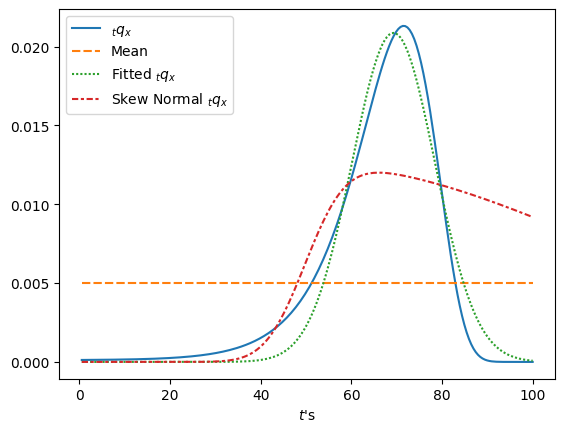

In [6]:
# fitted_qf = lambda t: skewnorm.pdf(t, 0, 75, 19)

fitting_data = pd.DataFrame({
    "$t$'s": ts[1:],
    "${}_t q_x$": qs,
    "Mean": qs_mean,
    "Fitted ${}_t q_x$": [fitted_qf(t) for t in ts[1:]],
    "Skew Normal ${}_t q_x$": [failed_fitted_qf(t) for t in ts[1:]],
}).set_index("$t$'s")

sns.lineplot(fitting_data)

## Part 2: The General Model